In [83]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils.functions as f

# Data Exploration

In [85]:
dataset = "direct_matching_20240213"  # "direct_matching_20240213" or "reverse_matching_20240213"
df_direct_matching = pd.read_csv(f"Data/{dataset}.csv", sep=";")
df_direct_matching.head()

,cand_id,job_id,distance_km,match_score,match_rank,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,cand_education,cand_languages_spoken,job_contract_type,job_professional_category,job_sector,job_work_province
0,"5,664,912",OFF_1011_1427,32.327042,99.573387,1,Male,45-54,UD,FRIULI VENEZIA GIULIA,NaN,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD
1,"4,999,120",OFF_1011_1427,15.595593,99.210564,2,Male,35-44,UD,FRIULI VENEZIA GIULIA,NaN,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD
2,"5,413,671",OFF_1011_1427,31.348877,99.118614,3,Female,45-54,UD,FRIULI VENEZIA GIULIA,NaN,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD
3,"5,965,090",OFF_1011_1427,66.315598,97.409767,4,Male,15-24,TS,FRIULI VENEZIA GIULIA,NaN,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD
4,"5,771,219",OFF_1011_1427,15.595593,97.323875,5,Female,35-44,UD,FRIULI VENEZIA GIULIA,NaN,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD


In [86]:
# Null values
null_values = df_direct_matching.isnull().sum()
print(null_values)

cand_id                         0
job_id                          0
distance_km                     0
match_score                     0
match_rank                      0
cand_gender                     0
cand_age_bucket                 1
cand_domicile_province          3
cand_domicile_region            5
cand_education               6306
cand_languages_spoken        6292
job_contract_type               0
job_professional_category       0
job_sector                      0
job_work_province               0
dtype: int64


In [87]:
# Remove rows with null values in columns = ['cand_age_bucket', 'cand_domicile_province', 'cand_domicile_region']
df_direct_matching = df_direct_matching.dropna(
    subset=["cand_age_bucket", "cand_domicile_province", "cand_domicile_region"]
)

In [88]:
# Print types of columns
print(df_direct_matching.dtypes)

cand_id                       object
job_id                        object
distance_km                  float64
match_score                  float64
match_rank                     int64
cand_gender                   object
cand_age_bucket               object
cand_domicile_province        object
cand_domicile_region          object
cand_education                object
cand_languages_spoken         object
job_contract_type             object
job_professional_category     object
job_sector                    object
job_work_province             object
dtype: object


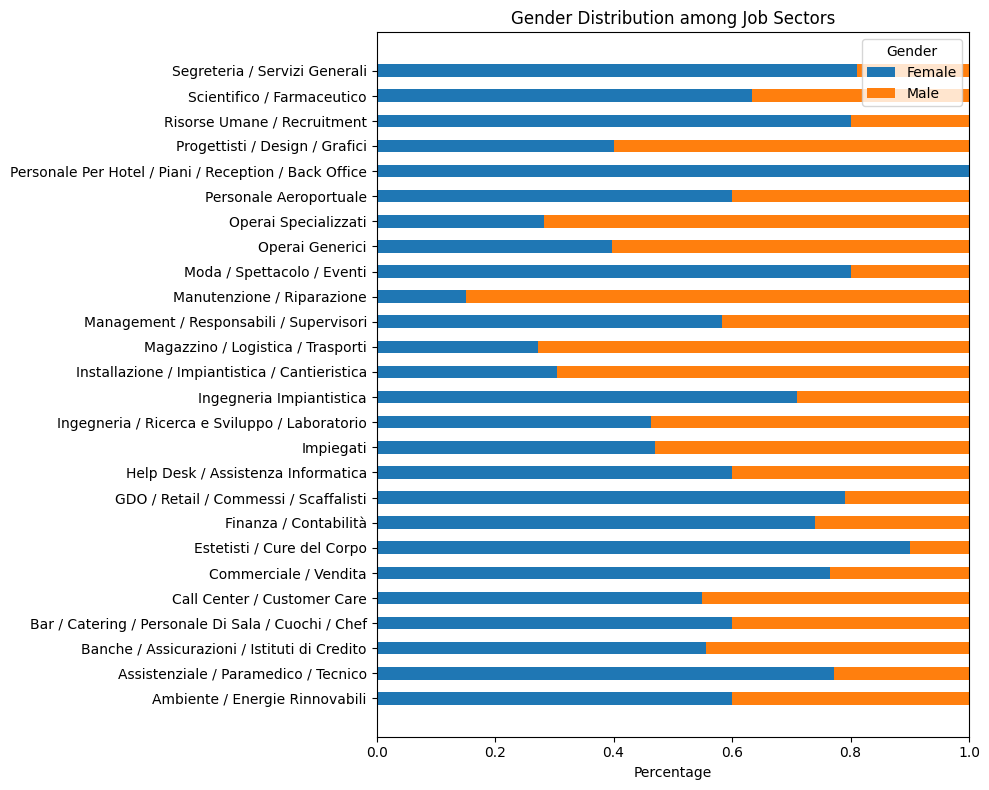

In [89]:
# Visualize gender distribution
f.plot_gender_distribution(df_direct_matching, "job_sector", "cand_gender")

# Preprocessing

In [90]:
df_processed = f.process_full_dataset(df_direct_matching)

In [91]:
df_processed.to_csv(f"Data/{dataset}_processed.csv", sep=";", index=False)

In [92]:
df_processed = pd.read_csv(f"Data/{dataset}_processed.csv", sep=";")

# Bias Detection

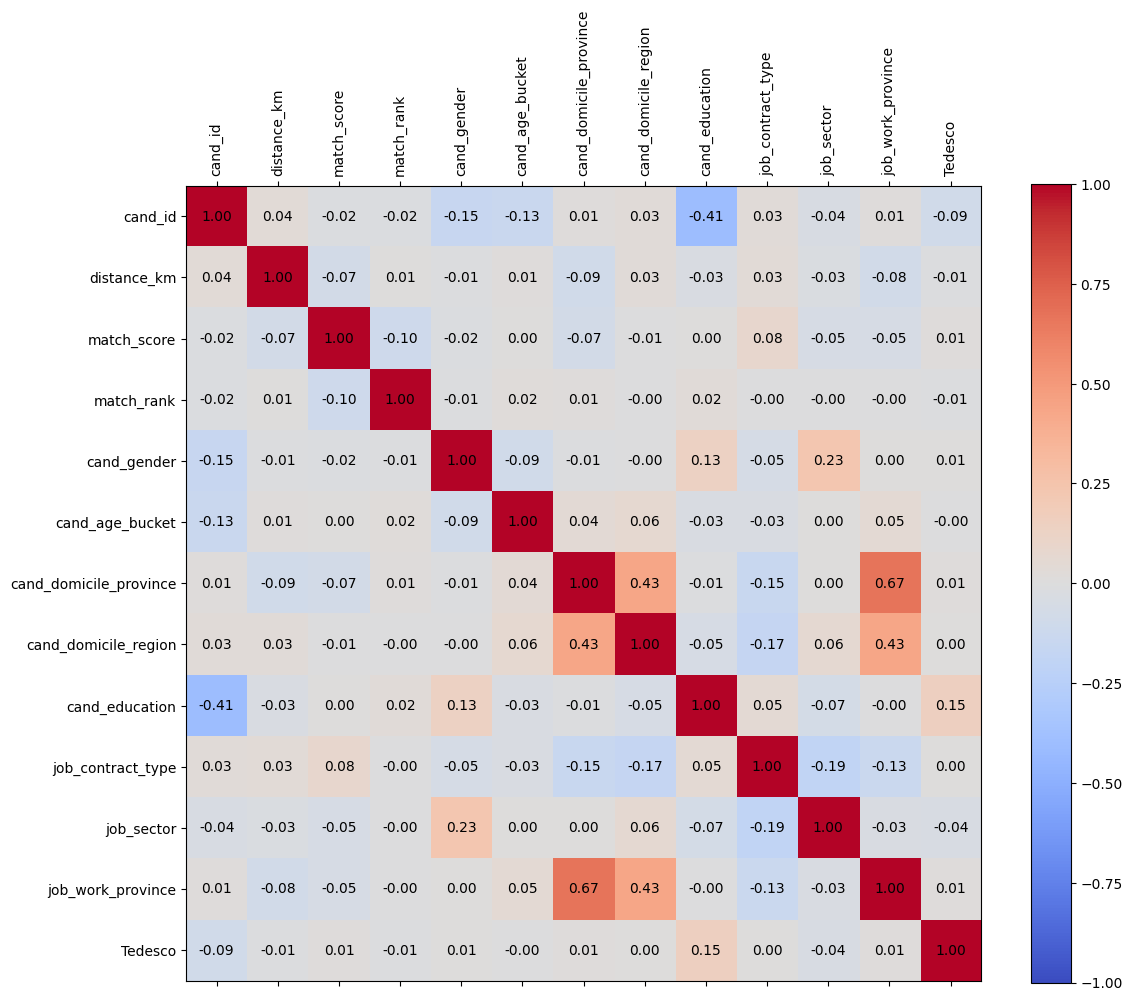

In [93]:
correlation = (
    df_processed[df_processed.columns[:15]].select_dtypes(include=[np.number]).corr()
)

# Plot the correlation matrix with values
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.matshow(correlation, cmap="coolwarm", vmin=-1, vmax=1)
fig.colorbar(cax)

# Adding the text inside the squares
for (i, j), val in np.ndenumerate(correlation.values):
    ax.text(j, i, f"{val:.2f}", ha="center", va="center")

plt.xticks(range(len(correlation.columns)), correlation.columns, rotation=90)
plt.yticks(range(len(correlation.columns)), correlation.columns)
plt.tight_layout()
plt.show()

In [26]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric

# Assuming direct_matching_df is your pandas DataFrame
# Convert your DataFrame to AIF360's StandardDataset format
new_df = df_processed[df_processed.columns[:15]].select_dtypes(include=[np.number])
dataset = StandardDataset(
    df=new_df,
    label_name="match_rank",
    favorable_classes=[1],
    protected_attribute_names=["cand_gender"],
    privileged_classes=[[0]],  # Assuming 0 represents male and 1 represents female
)
# Calculate the baseline metrics
metric_orig = BinaryLabelDatasetMetric(
    dataset,
    unprivileged_groups=[{"cand_gender": 1}],
    privileged_groups=[{"cand_gender": 0}],
    # unprivileged_groups=[{'cand_age_bucket': 0}],
    # privileged_groups=[{'cand_age_bucket': 1}, {'cand_age_bucket': 2}, {'cand_age_bucket': 3}, {'cand_age_bucket': 4}]
)
print("Original Dataset:")
print("1. Disparate Impact:", metric_orig.disparate_impact())
print("2. Mean Difference:", metric_orig.mean_difference())
print("3. Statistical Parity Difference:", metric_orig.statistical_parity_difference())

Original Dataset:
1. Disparate Impact: 1.0151109090161023
2. Mean Difference: 0.0032543247956225985
3. Statistical Parity Difference: 0.0032543247956225985


In [27]:
# Assuming direct_matching_df is your pandas DataFrame
# Convert your DataFrame to AIF360's StandardDataset format
dataset = StandardDataset(
    df=new_df,
    label_name="match_rank",
    favorable_classes=[1],
    protected_attribute_names=["cand_age_bucket"],
    privileged_classes=[[0], [1], [2], [3], [4]],  # Assuming age buckets from 0 to 4
)

# Calculate the baseline metrics
metric_orig = BinaryLabelDatasetMetric(
    dataset,
    unprivileged_groups=[{"cand_age_bucket": 4}],
    privileged_groups=[
        {"cand_age_bucket": 0},
        {"cand_age_bucket": 1},
        {"cand_age_bucket": 2},
        {"cand_age_bucket": 3},
    ],
)
print("Original Dataset:")
print("1. Disparate Impact:", metric_orig.disparate_impact())
print("2. Mean Difference:", metric_orig.mean_difference())

Original Dataset:
1. Disparate Impact: 0.9726568594383882
2. Mean Difference: -0.005947726916356144


In [28]:
new_df.describe()

,cand_id,distance_km,match_score,match_rank,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,cand_education,job_contract_type,job_sector,job_work_province
count,1.934740e+05,193474.000000,193474.000000,193474.000000,193474.000000,193474.000000,193474.000000,193474.000000,193474.000000,193474.000000,193474.000000,193474.000000
mean,5.101969e+06,38.210087,91.837911,2.923726,0.504957,1.726914,57.218841,9.396818,1.636303,0.963654,20.377053,61.853970
std,2.077592e+06,27.047254,12.394169,1.416097,0.499977,1.159209,31.095444,4.890240,2.282640,0.996187,10.351149,32.719076
min,1.120800e+04,0.000000,30.001501,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.063400e+06,16.593061,90.506653,2.000000,0.000000,1.000000,32.000000,6.000000,0.000000,0.000000,11.000000,37.000000
50%,5.842154e+06,32.815426,96.752945,3.000000,1.000000,1.000000,54.000000,8.000000,0.000000,0.000000,21.000000,53.000000
75%,6.670310e+06,57.491835,98.881617,4.000000,1.000000,3.000000,85.000000,11.000000,4.000000,2.000000,28.000000,93.000000
max,7.842895e+06,99.997292,99.999260,5.000000,1.000000,4.000000,107.000000,20.000000,8.000000,2.000000,42.000000,107.000000


In [29]:
import fairlens as fl

In [31]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193474 entries, 0 to 193473
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   cand_id                 193474 non-null  int32  
 1   distance_km             193474 non-null  float64
 2   match_score             193474 non-null  float64
 3   match_rank              193474 non-null  int64  
 4   cand_gender             193474 non-null  int32  
 5   cand_age_bucket         193474 non-null  int64  
 6   cand_domicile_province  193474 non-null  float64
 7   cand_domicile_region    193474 non-null  float64
 8   cand_education          193474 non-null  int64  
 9   job_contract_type       193474 non-null  int64  
 10  job_sector              193474 non-null  float64
 11  job_work_province       193474 non-null  float64
dtypes: float64(6), int32(2), int64(4)
memory usage: 16.2 MB


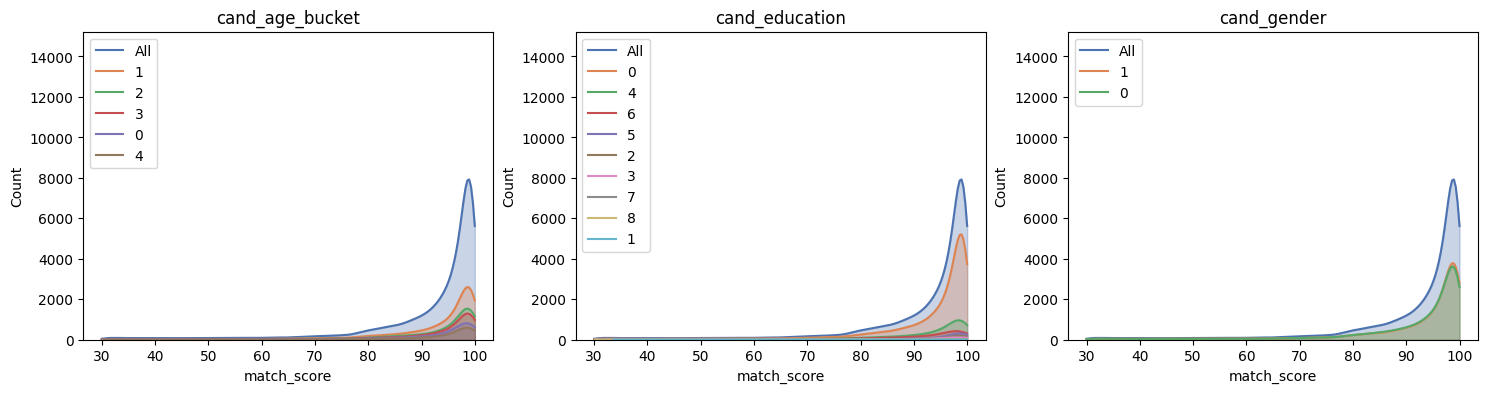

In [39]:
target_attr = "match_score"
sensitive_attr = ["cand_gender", "cand_age_bucket", "cand_education"]
fscorer = fl.FairnessScorer(new_df, target_attr, sensitive_attr)

fscorer.plot_distributions()